In [85]:
import scipy.io as sio

# load data from the .mat file:
# mat_contents = sio.loadmat('EEG_big.mat') # (EEG_data.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big4CNN.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/EEG_big4CNN_1subj.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_noICA->0.5-38Hz,Env=1.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->0.5-38Hz,Env=1.mat')

# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_ICA->0.5-38Hz,Env=1.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->1-48Hz,Env=1.mat')

# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_TD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_FD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_0101T_TD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_0202T_TD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_0403T_TD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_0503T_TD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_0801T_TD.mat')

# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/ks.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/ks_FD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/ks_2TD.mat')
mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/ksenia2_long_chunked.mat') 


# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_FD_fullspectrum.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/BCI_FD_lowspectrum.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/KOS_100Hz_ICA->1-38Hz,Env=1_FD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->1-100Hz,Env=1_FD')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->1-47Hz,Env=1_FD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->15-47Hz,Env=1_TD.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->15-47Hz,Env=1_TD5_64_.mat')
# mat_contents = sio.loadmat('/home/amplifier/home/DATASETS/Merged123->2-30Hz,Env=1_TD5_64_.mat')


BATCH_SIZE = 20
SHUFFLE = True
TEST_TRAIN = 0.2

KERNEL_SIZE = ((100), (20,1), (2,2))

N_KERNELS = (100,200,400)
POOL_SIZE = ((5),(5,5),(2,1))

DROPOUT = (0.2, 0.3, 0.6, 0.7)
DENSE_LEN = 10

In [86]:
# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = mat_contents['X']
Y = mat_contents['Z']
    

if Y.shape[1] > Y.shape[0]:
    Y = Y.T
    
print('Original data shape:', X.shape)
print('Original labels shape:', Y.shape)

# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
# Y = np.random.permutation(Y)


# winsize = mat_contents['winsize']
# stepsize = mat_contents['stepsize']
# trial_len = mat_contents['trial_len']
# low_cutoff = mat_contents['low_cutoff']
# high_cutoff = mat_contents['high_cutoff']
# source = mat_contents['filein']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_TRAIN, shuffle=SHUFFLE)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and zero mean:
# for i in range(x_train.shape[0]):
#     for j in range(x_train.shape[1]):
#         x_train[i,j,:] = preprocessing.scale(x_train[i,j,:])
# #         x_train[i,j,:] = preprocessing.MaxAbsScaler(x_train[i,j,:])

# for i in range(x_test.shape[0]):
#     for j in range(x_test.shape[1]):
#         x_test[i,j,:] = preprocessing.scale(x_test[i,j,:])
# #         x_test[i,j,:] = preprocessing.minmax_scale(x_test[i,j,:])

# ensure the tensors are sized right:
if len(X.shape)==3:
    x_train = np.expand_dims(x_train,3)
    x_test = np.expand_dims(x_test,3)
    

# one hot encode the labels:
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
y_train = onehot_encoder.fit_transform(y_train)
y_test = onehot_encoder.fit_transform(y_test)

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

chan = X.shape[1] # if you work in the FD, this is the height of the sample time-frequency image, othewise EEG channels
leng = X.shape[2] # if you work in the FD, this is the width of the sample time-frequency image, othewise time samples of EEG signal

if len(X.shape)==3:
    streams = 1 # this is EEG channels if you work with frequency domain, in the TD streams = 1
if len(X.shape)==4:
    streams = X.shape[3] # this is EEG channels if you work with frequency domain, in the TD streams = 1


print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

# print('Window length', winsize)
# print('Step size:', stepsize)
# print('Trial length:', trial_len)

Original data shape: (134, 24, 500)
Original labels shape: (134, 1)
Original data type: float64
Normalized data type: float16
test input shape (27, 24, 500, 1) Nomralized MEAN: -0.0017519 min -65.188 max 164.0
train input shape (107, 24, 500, 1) Nomralized MEAN: 0.00096178 min -73.625 max 161.62
test labels shape (27, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0
train labels shape (107, 2) Nomralized MEAN: 0.5 min 0.0 max 1.0


In [87]:
# we first define the autoencoder's architecture:

# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Dense, Conv2D, Conv1D, ELU, Permute, Lambda, Flatten
from keras.layers import MaxPooling2D, MaxPooling2D, MaxPooling1D, Dropout, BatchNormalization
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.initializers import Orthogonal as orth

import numpy as np
import matplotlib.pyplot as plt

def Squeeze(input_img):
    return K.squeeze(input_img, axis=3)

def Exp_dims(input_img):
    return K.expand_dims(input_img, axis=3)

def conv_net(leng):
    print(leng)
    input_img = Input(shape=(chan, leng, streams))  # adapt this if using `channels_first` image
    squeezed = Lambda(Squeeze)(input_img)
    perm_img = Permute((2,1))(squeezed)
    input_norm = BatchNormalization()(perm_img)
    e1 = Conv1D(N_KERNELS[0], KERNEL_SIZE[0], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(input_norm)
    e1act = ELU(alpha=1.0)(e1)
    e1p = MaxPooling1D(POOL_SIZE[0], padding='same')(e1act)
    e1e = Lambda(Exp_dims)(e1p)
    

    e2b = BatchNormalization()(e1e)
    e2a = Dropout(DROPOUT[0])(e2b)
    e2c = Conv2D(N_KERNELS[1], KERNEL_SIZE[1], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e2a)
    e2act = ELU(alpha=1.0)(e2c)
    e2p = MaxPooling2D(POOL_SIZE[1], padding='same')(e2act)
    
    

    e3b = BatchNormalization()(e2p)
    e3a = Dropout(DROPOUT[1])(e3b)
    e3c = Conv2D(N_KERNELS[2], KERNEL_SIZE[2], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e3a)
    e3act = ELU(alpha=1.0)(e3c)
    e3p = MaxPooling2D(POOL_SIZE[2], padding='same')(e3act)
      
    e10 = Flatten()(e3p)
    e10b = BatchNormalization()(e10)
    e10d = Dropout(DROPOUT[2])(e10b)
    e11 = Dense(DENSE_LEN, activation='sigmoid',
                                     kernel_initializer = orth(gain=1.0, seed=None))(e10d)
    e12 = Dropout(DROPOUT[3])(e11)
    e12b = BatchNormalization()(e12)
    e13 = Dense(2, activation='softmax')(e12b)

    return Model(input_img, e13)

In [88]:
# define input to the model:
x = Input(shape=(chan, leng, streams))

# make the model:
model = conv_net(leng)

# compile the model:
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.95, nesterov=True)
# model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
# model.compile(optimizer='rmsprop', loss=correlation_coefficient_loss)
model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])


# SEE INSIDE THE MODEL:
# conv_net().summary() #or
model.summary()

500
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 24, 500, 1)        0         
_________________________________________________________________
lambda_25 (Lambda)           (None, 24, 500)           0         
_________________________________________________________________
permute_13 (Permute)         (None, 500, 24)           0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 500, 24)           96        
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 500, 100)          240100    
_________________________________________________________________
elu_25 (ELU)                 (None, 500, 100)          0         
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 100, 100)          0         
______

In [89]:
# Training time!
early_stopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')
checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/EEGnet_weights_VERT.h5',
                               verbose=1,
                               monitor='val_acc',
                               save_best_only=True)
TB = TensorBoard(log_dir='/home/amplifier/home/CNN_stim')

train_history = model.fit(x_train, y_train,
                epochs=1000,
                batch_size=BATCH_SIZE,
                verbose=2,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TB, checkpointer, early_stopping])

# model.save('/home/amplifier/home/NEW_DL/models/EEGnet.h5')

Train on 107 samples, validate on 27 samples
Epoch 1/1000

Epoch 00001: val_acc improved from -inf to 0.55556, saving model to /home/amplifier/home/NEW_DL/weights/EEGnet_weights_VERT.h5
 - 2s - loss: 0.7522 - acc: 0.6168 - val_loss: 0.6750 - val_acc: 0.5556
Epoch 2/1000

Epoch 00002: val_acc did not improve
 - 0s - loss: 0.6509 - acc: 0.6542 - val_loss: 0.6334 - val_acc: 0.5556
Epoch 3/1000

Epoch 00003: val_acc improved from 0.55556 to 0.59259, saving model to /home/amplifier/home/NEW_DL/weights/EEGnet_weights_VERT.h5
 - 0s - loss: 0.5532 - acc: 0.7009 - val_loss: 0.6720 - val_acc: 0.5926
Epoch 4/1000

Epoch 00004: val_acc did not improve
 - 0s - loss: 0.5503 - acc: 0.7009 - val_loss: 0.7279 - val_acc: 0.5926
Epoch 5/1000

Epoch 00005: val_acc did not improve
 - 0s - loss: 0.6340 - acc: 0.7009 - val_loss: 0.7154 - val_acc: 0.5926
Epoch 6/1000

Epoch 00006: val_acc did not improve
 - 0s - loss: 0.5040 - acc: 0.7570 - val_loss: 0.7485 - val_acc: 0.5926
Epoch 7/1000

Epoch 00007: val_acc

Epoch 64/1000

Epoch 00064: val_acc did not improve
 - 0s - loss: 0.2650 - acc: 0.9065 - val_loss: 1.0651 - val_acc: 0.5926
Epoch 65/1000

Epoch 00065: val_acc did not improve
 - 0s - loss: 0.2450 - acc: 0.8785 - val_loss: 1.0583 - val_acc: 0.5926
Epoch 66/1000

Epoch 00066: val_acc did not improve
 - 0s - loss: 0.2186 - acc: 0.9626 - val_loss: 1.0887 - val_acc: 0.5926
Epoch 67/1000

Epoch 00067: val_acc did not improve
 - 0s - loss: 0.2296 - acc: 0.9439 - val_loss: 1.0742 - val_acc: 0.5926
Epoch 68/1000

Epoch 00068: val_acc did not improve
 - 0s - loss: 0.2234 - acc: 0.9346 - val_loss: 1.1084 - val_acc: 0.5926
Epoch 69/1000

Epoch 00069: val_acc did not improve
 - 0s - loss: 0.1712 - acc: 0.9720 - val_loss: 1.1046 - val_acc: 0.5926
Epoch 70/1000

Epoch 00070: val_acc did not improve
 - 0s - loss: 0.1692 - acc: 0.9439 - val_loss: 1.1357 - val_acc: 0.5556
Epoch 71/1000

Epoch 00071: val_acc did not improve
 - 0s - loss: 0.1909 - acc: 0.9533 - val_loss: 1.1164 - val_acc: 0.5556
Epoch 72

In [90]:
# load the best model:
model.load_weights('/home/amplifier/home/NEW_DL/weights/EEGnet_weights_VERT.h5')

# let's predict a TRAINING sammple:
decoded_train = model.predict(x_train)
decoded_test = model.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(107, 2)
(27, 2)


[[13  2]
 [ 5  7]]


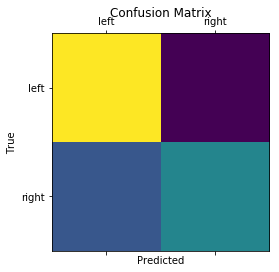

In [91]:
W = []
GT = []

for i in range(len(decoded_test)):
    if decoded_test[i][0]<decoded_test[i][1]:
        W.append('right')
    if decoded_test[i][0]>decoded_test[i][1]:
        W.append('left')

    if y_test[i][0]<y_test[i][1]:
        GT.append('right')
    if y_test[i][0]>y_test[i][1]:
        GT.append('left')
        
from sklearn.metrics import confusion_matrix
labels = ['left', 'right'] # 1 for right, 0 for left
cm = confusion_matrix(GT, W, labels)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.matshow(cm)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
print(cm)

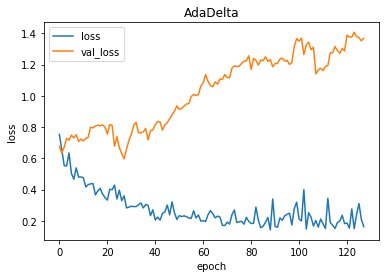

In [92]:
#####################################################

# print(np.array(history.losses))
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('AdaDelta')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [93]:
##########################################################

# now test sample by sample
cor_test = []
L = x_test.shape
for sample_no in range(x_test.shape[0]):
    pred = model.predict(np.expand_dims(x_test[sample_no],0))
    if ((pred[0][0]<pred[0][1]) and (y_test[sample_no,0] < y_test[sample_no,1]) or
       ((pred[0][0]>pred[0][1]) & (y_test[sample_no,0] > y_test[sample_no,1]))):
        cor_test.append(1)
    else:
        cor_test.append(0)

cor_train = []
L = x_train.shape
for sample_no in range(x_train.shape[0]):
    pred = model.predict(np.expand_dims(x_train[sample_no],0))
    if ((pred[0][0]<pred[0][1]) and (y_train[sample_no,0] < y_train[sample_no,1]) or
       ((pred[0][0]>pred[0][1]) & (y_train[sample_no,0] > y_train[sample_no,1]))):
        cor_train.append(1)
    else:
        cor_train.append(0)

# Report accuracies
print('Accuracy on the test data:', np.mean(cor_test))
print('Accuracy on the training data:', np.mean(cor_train))

Accuracy on the test data: 0.740740740741
Accuracy on the training data: 0.943925233645


In [94]:
# Visualize a few kernels from the first convolutional layer:
# enc.layers[2].get_config()
# dir(enc.layers[2])
x = model.layers[2].get_weights()
print ('Layer number:', 2, 'Layer name:', model.layers[2].name)
sh = x[0].shape
print(sh) # kernel length x input channels x output channels

c = 0
fig, axs = plt.subplots(sh[2],sh[3])
fig.set_size_inches(18.5, 10.5)
axs = axs.ravel()
for i in range(sh[2]):
    for j in range(sh[3]):
        axs[c].imshow(x[0][:,:,i,j])
        axs[c].get_xaxis().set_visible(False)
        axs[c].get_yaxis().set_visible(False)        
        axs[c].set_title(str(i)+str(j))
        c = c + 1
plt.suptitle(('Convolution kernels in layer ' + model.layers[2].name), fontsize=16)

Layer number: 2 Layer name: permute_13


IndexError: list index out of range

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))